In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import json
import re
import numpy as np
import pickle
import fasttext.util
import torch
from sklearn.decomposition import PCA
from random import sample
import nltk
from nltk.tokenize import RegexpTokenizer

## Build Corpus (No need to run again)

Let's compute the emebeddings for each word appearing in the tweets we analyze. First, let's load our tweeter data.

In [ ]:
tweets = pd.read_pickle('data/tweets.pkl.bz2', compression='bz2')
tweets.head()

Clean the tweets text from all unwanted characters.

In [ ]:
def clean_tweets(x):
    x = x.lower()
    x = x.replace('\n',' ')
    # remove @
    cleaned_string = re.sub("@[A-Za-z0-9_]+",'', x)
    # remove hashtag
    cleaned_string = re.sub("#","", cleaned_string)
    # remove url
    cleaned_string = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b','', str(cleaned_string), flags=re.MULTILINE)
    
    # remove emojis
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    cleaned_string = regrex_pattern.sub(r'',  cleaned_string)
        
        
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', cleaned_string)
    return cleaned_string

tqdm.pandas() 
text_clean = tweets['text'].progress_map(clean_tweets)

We can apply now the word tokenization.

In [ ]:
# cleaned text example
text_clean.head(2).values

In [ ]:
print('Tokenizing...')
tokenizer = RegexpTokenizer('[a-zA-Z0-9]\w+')
tokens = [tokenizer.tokenize(tweet) for tweet in tqdm(text_clean)]

In [ ]:
# token example
tokens[1][:10]

Now, let's load the model for word embedding. For this task, we use the `fasttext` model, the same model we use to perform document emeddings and use for classification of the winning pair in the BTM model.

In [ ]:
ft = fasttext.load_model('cc.en.300.bin')
ft.get_dimension()

Model will use 300 emebddings to represent each word, again the same as our BTM models. Let's save embedding of each word in a dictionarly.

In [ ]:
dic_wv = {}
dic_count = {}
word_out = []
from nltk.probability import FreqDist
fdist = FreqDist()

for tweet in tqdm(tokens):
    for w in tweet:
        try :
            emb = ft.get_word_vector(w)
            dic_wv.update({w : emb})
            fdist[w] += 1
        except: 
            word_out = word_out.append(w)
            continue
            
word_out

In [ ]:
# most common words
fdist.most_common(20)

In [ ]:
# let's create a dictonary, so we can save it and re-use it latter
df_dict = pd.DataFrame(dic_wv)
df_dict = df_dict.transpose()
# add frequency column, so we can later sort out words that appear very rarely in our 
df_dict['frequency'] = df_dict.index.map(fdist)
df_dict

In [ ]:
# saving results, no need to re-run this part of the code anymore
df_dict.to_pickle('data/dictionary.pkl.bz2',compression='bz2')

# Interpretation and results

Let's perform the interpretation of the results for each of our models. 

In [2]:
# load the dictionarly of words properly embedded with fasttext model
word_dict = pd.read_pickle('data/dictionary.pkl.bz2',compression='bz2')
word_dict.head(10)

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,frequency
the,-0.051744,0.073964,-0.013057,0.044727,-0.034320,0.021217,0.006911,-0.016328,-0.018075,-0.001997,...,-0.043851,-0.057783,0.022305,-0.077707,-0.043200,-0.025055,0.237025,0.000448,-0.004193,11618962
business,-0.017487,0.020500,0.000451,0.054434,-0.039927,0.062925,0.068717,0.011007,0.015244,0.012434,...,0.008133,-0.013571,0.031492,0.000884,-0.012069,-0.016879,0.047419,-0.021857,0.010632,111104
of,-0.000073,-0.187741,-0.071051,-0.463249,0.000198,0.011507,-0.058770,0.057424,-0.027523,-0.003555,...,-0.003260,-0.110302,0.209506,-0.129082,-0.025329,-0.000130,0.028464,-0.138433,0.018054,5963667
businesses,-0.061112,-0.004327,-0.012538,0.023134,-0.034560,0.070083,0.032714,0.021947,0.022434,-0.024259,...,0.041731,0.002915,0.053857,-0.015089,-0.026255,0.017314,0.034396,0.047284,0.040676,40576
is,-0.097761,-0.208274,-0.103724,-0.016017,-0.240252,-0.044891,0.002990,0.099000,-0.040384,-0.050430,...,0.036204,-0.182370,0.140774,-0.086790,0.024272,0.065999,-0.228168,-0.224439,0.088975,3573270
climate,-0.061201,-0.044101,0.052812,0.028528,-0.009690,-0.051965,0.125549,0.052652,0.024313,-0.003412,...,0.005459,-0.055302,0.055475,0.071550,0.019467,0.016512,0.076031,0.101524,0.006836,6192868
change,-0.007493,-0.034452,0.104169,0.066362,-0.034571,0.005040,0.059079,-0.003307,0.079157,-0.035220,...,-0.015609,-0.043801,0.093743,-0.028820,-0.021110,0.066493,0.025492,-0.026088,0.050044,4865833
adaptation,-0.029979,0.020005,0.028403,-0.009479,0.034283,0.005465,0.042043,-0.017170,0.027767,0.047473,...,-0.000711,-0.024324,0.050993,0.007938,-0.017744,-0.005726,0.026292,-0.011898,-0.014605,62466
from,-0.038780,0.295721,-0.067825,0.012749,-0.010165,0.024265,0.038572,0.015152,-0.022139,-0.039315,...,0.009713,0.007391,0.022134,-0.000595,-0.000393,-0.022809,-0.006754,-0.010405,0.055893,1312824
title,-0.059397,0.040238,0.021163,0.044048,0.080998,0.019510,-0.051890,-0.009594,-0.050363,0.061991,...,-0.062835,-0.019776,0.054980,-0.016222,-0.024671,-0.102561,0.037012,-0.107401,0.053999,2087611


## Inital BTM Model

Let's start with analyzing the reults of the inital BTM model.

In [3]:
class LogRegression(torch.nn.Module):
    def __init__(self, input_dim):
        super(LogRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, 1, bias=False)
    
    def forward(self, x):
        return self.linear(x)
    
model = LogRegression(300)
model.load_state_dict(torch.load("Models/btm-inital-time10%.pth"))
model.eval()

for p in model.parameters():
    print("Learned weights shape:", p.shape)
    weights = p
    weights.requires_grad = False

Learned weights shape: torch.Size([1, 300])


Let's compute the significants scores for each word based on the weights of the initial BTM model.

In [4]:
scores = weights.numpy() @ (word_dict.iloc[:, :-1]).T
scores.shape

(1, 943617)

In [5]:
word_dict['init_scores'] = scores.squeeze(0)
word_dict.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,frequency,init_scores
langleycentennialmuseum,-0.011529,0.006288,-0.002964,-0.000962,-0.017661,-0.027268,0.015004,-0.016484,0.002584,-0.023646,...,-0.020030,0.000562,-0.023445,-0.030642,0.015719,0.025715,0.010982,-0.006227,1,-0.592699
socialistforphilly,0.000213,0.006705,0.015058,0.039512,-0.008240,-0.031134,0.000492,0.001310,-0.001374,0.001848,...,-0.008845,-0.008571,0.007773,0.004088,-0.006679,0.003736,0.005388,-0.025270,4,-0.121683
thiuhh,0.064205,0.006913,0.007344,0.090097,-0.038513,-0.031611,-0.031327,0.042327,0.049429,-0.016083,...,-0.015248,-0.020822,0.042858,-0.013547,-0.007004,0.023867,0.005428,-0.069663,1,0.656045
leonid,0.018100,-0.033515,-0.041982,0.080057,0.074641,-0.173185,-0.002092,0.061799,0.021735,0.006183,...,-0.156363,0.045094,-0.055410,0.026767,0.026520,0.081744,-0.049979,-0.110094,14,0.791896
prothonotary,0.046778,0.044155,-0.014963,0.035642,0.021680,-0.039050,0.016940,0.005909,-0.057210,-0.078795,...,-0.026787,0.008962,0.031601,-0.037690,0.052585,0.031380,-0.050495,-0.013907,2,0.326321


In [6]:
word_dict["frequency"].describe()

count    9.436170e+05
mean     2.855115e+02
std      2.174821e+04
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      4.000000e+00
max      1.161896e+07
Name: frequency, dtype: float64

In [7]:
# the most frequent words
word_dict['frequency'].sort_values(ascending=False).head()

the        11618962
to          7926513
climate     6192868
of          5963667
and         5911455
Name: frequency, dtype: int64

We can see that majority of words we saw only appears just once or couple of times. We can consider that these words are not relevant as their frequency and usage is extremly rare. Usually, they don't represent real words of English nor some wide-known acronymes, hence we can dicared them. From the statistics above, we notice that median is equal to $1$, so let's consider only words, appearling more than once (word must be repeat more than once to be considered as "real", i.e., otherwis we can just consider it as just a typo or non-existing word). 

Also, we can discard the two most frequent words ,`to` and `the`, as they are also non-significant for our analysis. 

In [8]:
word_dict_freq = word_dict[(word_dict['frequency'] > 1) & (
    word_dict['frequency'] < 0.7e7)][["frequency", "init_scores"]]
word_dict_freq["frequency"].describe()

count    4.363080e+05
mean     5.715244e+02
std      2.386150e+04
min      2.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      1.500000e+01
max      6.192868e+06
Name: frequency, dtype: float64

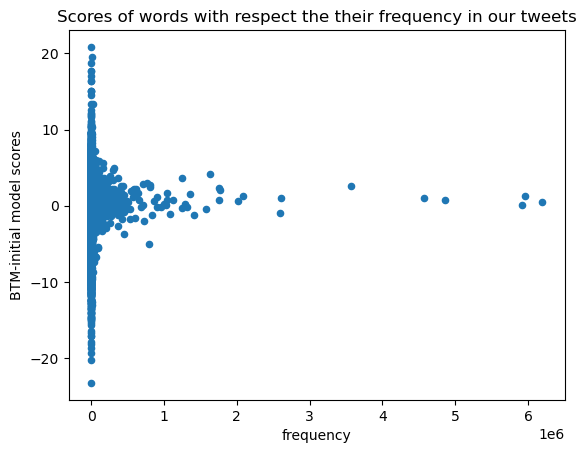

In [9]:
word_dict_freq.plot.scatter(x="frequency", y="init_scores")
plt.ylabel("BTM-initial model scores")
plt.title("Scores of words with respect the their frequency in our tweets")
plt.show()

In [10]:
word_dict_freq['init_scores'].describe()

count    436308.000000
mean         -0.133154
std           1.154083
min         -23.252186
25%          -0.602291
50%          -0.141302
75%           0.334704
max          20.850218
Name: init_scores, dtype: float64

Let's check the words with the strongest significance.

In [11]:
word_dict_freq.sort_values(by='init_scores', ascending=False, inplace=True)
word_dict_freq.head(30)

,frequency,init_scores
sq,989,20.850218
kg,16944,19.467094
m2,171,18.693216
s8,11,17.754915
k5,7,17.729942
km2,258,17.032694
hf,149,16.359928
hz,34,16.340261
288b,4,15.044006
px,66,15.035110


In [12]:
np.array(word_dict_freq.index)[0:200]

array(['sq', 'kg', 'm2', 's8', 'k5', 'km2', 'hf', 'hz', '288b', 'px',
       'ico', 'cm', 'km3', 'mp', 's2', '0s', 'k8', '27t', '27s', 'ww3',
       'wmd', 'kv', 'mv', 'ddamn', 'atf', 'mbt', 'mc2', 'mm', 'mc', 'nm',
       'g9', 'm1', 'g5', 'qv', 'g1', 'afk', 'o2', 'e8', 'a7', 'kgs', 'fg',
       'k3', 'wt', 'fkn', 'ck', '9951', 'g3', '95', 'uv', 'othes', 'gwb',
       'kz', 'pz', '5d', 'ha', 'j9', 'ape', 'm9', 'hh', '7d', '99s', 's6',
       'f4', '2049', 'mi', 'nyt', 'a55', 'earthers', 'kd', 'zh', 'pbuh',
       'lb', 'pb', '60kg', 'wmw', 'ilk', 'gsm', 'scp', 'cd', 'rug', 'sv',
       'dnc', 'u2', 'kgm', 'g4', 'dq', '1m2', 'tfa', 'dmt', 'ffs', 'obc',
       'mj', 'kgf', 'shp', 'sqkm', 'oq', 'awe', '10w', 'niva', 'pope',
       'dbh', 's5', '60w', 'o3', 'lcd', '6kg', '80kg', 'isk', 'imax',
       'apes', 'zod', 'azz', 'g8', 'miley', '3959', 'og', 'k6', 'km',
       'msm', 'sh', 'm3', '3680', 'bs', 'nul', 's3', 'yak', '90', 'btn',
       'dc', 'ps', 'e7', 'jps', 'utf8', 'kg2', '27m', '

Let's see what word appear to be the most neutral.

In [13]:
eps = 0.00005
word_dict_freq[(word_dict_freq['init_scores'] > 0 - eps) & (word_dict_freq['init_scores'] < 0 + eps)]

,frequency,init_scores
planttreessavenature,2,0.000039
climatejustice4africa,3,0.000036
solidaristic,3,0.000035
accumulationof,2,0.000031
p4b,16,0.000031
africabusiness,4,0.000026
neutrify,2,0.000023
aright,6,0.000023
pols3033,2,0.000016
noclimatecrisis,23,0.000014


Let's also check the words that should be avoided.

In [14]:
word_dict_freq.tail(30)

,frequency,init_scores
bi,1139,-13.534778
wye,120,-13.568633
fz,7,-13.734894
lordd,2,-13.896049
lmk,120,-14.004897
9g,9,-14.057755
npn,5,-14.095228
2j,11,-14.102715
d6,34,-14.257542
3z,12,-14.416529


We notice that many of the most imprtnat words appeare only couple of times in the tweets and that they represent some abreviations. Let's fillter out the results once again, but now for the words that don't appear more than 700 times in the text of the tweets.

In [15]:
word_dict_very_freq = word_dict[(word_dict['frequency'] > 700) & (
    word_dict['frequency'] < 0.7e7)][["frequency", "init_scores"]]
word_dict_very_freq.sort_values(by='init_scores', ascending=False, inplace=True)
word_dict_very_freq["frequency"].describe()

count    1.486500e+04
mean     1.605562e+04
std      1.283141e+05
min      7.010000e+02
25%      1.188000e+03
50%      2.403000e+03
75%      6.849000e+03
max      6.192868e+06
Name: frequency, dtype: float64

Let's now check the words with the strongest significance.

In [16]:
word_dict_very_freq.head(30)

,frequency,init_scores
sq,989,20.850218
kg,16944,19.467094
cm,2614,14.482622
mp,18473,13.417012
ww3,1249,11.675311
mv,736,10.729872
mm,5469,10.402201
mc,889,10.392258
nm,2064,10.349261
o2,745,9.611724


In [17]:
np.array(word_dict_very_freq.index)[0:200]

array(['sq', 'kg', 'cm', 'mp', 'ww3', 'mv', 'mm', 'mc', 'nm', 'o2', 'fg',
       'ck', '95', 'uv', 'ha', 'mi', 'nyt', 'rug', 'dnc', 'ffs', 'awe',
       'pope', 'km', 'msm', 'sh', 'bs', '90', 'dc', 'ps', 'ban', 'hq',
       'alt', 'bjp', '1kg', 'yr', 'gaga', 'peta', 'rot', 'gdp', 'lbs',
       '93', 'b4', 'ass', 'sad', '99', 'sue', 'cry', 'ghg', 'sc', 'mad',
       'suns', '2050', 'die', 'dam', 'nobel', 'ww2', 'rats', '2080', 'wu',
       'mn', 'ice', 'fu', 'ok', 'gop', 'olds', 'dd', 'dams', 'vow', 'pew',
       'nuke', 'stfu', '85', 'act', 'nazis', '40', '98', 'potus', 'rcmp',
       'lv', 'ch4', 'dems', 'af', 'wtf', 'sing', '27cm', 'nukes', 'txt',
       'dhs', 'iso', 'lied', 'fake', 'hoax', 'ship', 'liars', 'bc',
       'swan', 'mf', 'iucn', 'ie', 'ji', 'gmo', 'jul', 'extinct', 'sued',
       '3mm', 'idiots', 'obama', 'fbi', 'nwo', 'hug', 'ccp', '2045',
       'men', 'ms', 'ark', 'gaia', 'oil', 'omg', 'war', 'died', 'am',
       'mw', 'ppl', 'jail', 'wars', 'morons', '50', 'slap', '

Let's see what word appear to be the most neutral.

In [18]:
eps = 0.002
word_dict_very_freq[(
    word_dict_very_freq['init_scores'] > 0 - eps) & (word_dict_very_freq['init_scores'] < 0 + eps)]

,frequency,init_scores
430,1235,0.001983
philippine,1050,0.001974
graham,2762,0.001617
marshall,3446,0.001585
rooted,1704,0.001536
oromovoice,4569,0.001495
appreciating,794,0.001485
interference,888,0.001273
invites,3383,0.001240
ar6,2151,0.001170


Let's also check the words that should be avoided.

In [19]:
word_dict_very_freq.tail(30)

,frequency,init_scores
uga,5329,-8.153550
ipo,1374,-8.224037
nc,3409,-8.284756
ta,726,-8.296788
lo,1004,-8.579872
diy,1077,-8.603325
ap,21654,-8.645139
mo,2724,-8.967734
vix,2000,-8.994699
h2,1494,-9.006974


### Possible conclusions 

1. Specific numbers draw attention
2. More negative and angry words(cry, rats, liar, extinct) than positive word
3. Some celebrites such as pope, obama, putin, miley, (Bill) Nye 
4. nyt, wwf, fox, icun can be found, kind of proved their influence
5. Based on words, we can kind of infer some topics such as ecocide（extinct, died,), clmate change(ice, suns) and also Dirty energy (oil, exxon,fossil )
6. Swear words draw attention

## Model Meta Data

In [20]:
model_meta = LogRegression(305)
model_meta.load_state_dict(torch.load("Models/btm-meta-time10%.pth"))
model_meta.eval()

for p in model_meta.parameters():
    print(p.shape)
    weights = p
    weights.requires_grad = False

torch.Size([1, 305])


In [21]:
# embeddings weights
word_weight = weights.numpy()[:, :300]

# weights for meta features in order "urls_count", "hashtags_count", "animated_gif_count", "video_count", "image"
meta_weight = weights.numpy()[:, 300:]
meta_weight

array([[-0.08203267, -0.01377606,  0.05208312,  0.03962353,  0.03828091]],
      dtype=float32)

**Here we can conclude that having an image or video (and also GIF but to lesser extent) attached with the tweet helps in drawing attention, while having urls and hastags negatively influences tweets' success.**

In [22]:
scores = word_weight @ (word_dict.iloc[:, :300]).T
word_dict['meta_scores'] = scores.squeeze(0)
word_dict.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,293,294,295,296,297,298,299,frequency,init_scores,meta_scores
chesbayday22,-0.002693,0.031658,0.026884,0.041333,-0.032979,-0.074779,-0.004264,0.038381,0.019614,-0.045595,...,-0.024561,0.004743,-0.000301,-0.005842,0.025509,0.038858,0.012458,1,0.536825,1.446287
stemnews,-0.031228,0.033157,0.024671,0.049410,-0.090040,-0.025462,-0.014294,0.004556,-0.004541,-0.010075,...,-0.014554,0.011824,0.004538,-0.063226,0.039415,0.053546,-0.017264,6,-1.246248,-0.822115
reymir,0.002477,-0.011557,0.025874,0.008179,0.072192,0.020572,-0.059492,0.006889,-0.013219,-0.002537,...,-0.015215,0.051055,-0.036053,-0.049690,-0.000728,0.061276,-0.021182,3,-1.382340,-1.926803
bullshjt,0.000233,-0.007289,0.013662,0.027218,-0.008504,0.000226,0.021976,0.012667,-0.011579,-0.019473,...,0.014835,-0.007452,0.019182,0.002190,0.005495,0.003319,-0.014399,3,0.027752,0.546760
albertamustgo,0.037121,-0.011312,0.013133,0.047617,-0.007013,0.019076,-0.009088,0.045746,-0.010657,-0.029089,...,0.005996,0.006045,-0.012559,0.027940,0.034883,0.019333,-0.023228,11,0.415675,0.658188


Let's see if there is a difference in mean between scores.

In [23]:
(word_dict['meta_scores'] - word_dict['init_scores']).describe()

count    943617.000000
mean          0.179395
std           0.591204
min         -26.225080
25%          -0.065585
50%           0.205628
75%           0.477526
max          14.499269
dtype: float64

We can see that there is not too significant change between `meta` and `init` scores, although we can see that on average that scores got a little bit higher. 

Let's now check which words helped the most to tweets to be succesful. We will again filter out the words that only appear once (with the same reasoning behind the decision).

In [24]:
word_dict_freq = word_dict[(word_dict['frequency'] > 1) & (
    word_dict['frequency'] < 0.7e7)][["frequency", "init_scores", "meta_scores"]]
word_dict_freq.sort_values(by="meta_scores", inplace=True, ascending=False)
word_dict_freq["frequency"].describe()

count    4.363080e+05
mean     5.715244e+02
std      2.386150e+04
min      2.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      1.500000e+01
max      6.192868e+06
Name: frequency, dtype: float64

In [25]:
word_dict_freq.head(30)

,frequency,init_scores,meta_scores
s8,11,17.754915,32.254185
k5,7,17.729942,27.418570
m2,171,18.693216,25.800417
sq,989,20.850218,24.459322
km2,258,17.032694,22.231796
288b,4,15.044006,21.841488
k6,2,7.478906,21.332678
kg,16944,19.467094,21.214231
hf,149,16.359928,21.173647
ico,365,15.024370,20.479448


In [26]:
np.array(word_dict_freq.index)[0:210]

array(['s8', 'k5', 'm2', 'sq', 'km2', '288b', 'k6', 'kg', 'hf', 'ico',
       'px', 'k8', 'j9', 'hz', 'g9', 'ck', 's2', 'mp', 'g1', 'qv', 'mc',
       'hh', 'mbt', 'k3', 'e8', 'gsm', 'cm', 'pz', 'o2', 'k7', 'm1',
       'wmw', 'ha', 'm9', 'ddamn', 'k4', 'a7', '27t', 'km3', 'm8', 'atf',
       'niva', '0s', 'fkn', 'm7', 'o3', 'f9', 'nm', 'wmd', 'ww3', 'mc2',
       '7d', 'g3', 'oq', '9951', 'hq', '27s', 'kd', 'afk', 'f4', 'tfa',
       'lb', 'e7', 'gs', '5d', 'g6', 'azz', 'kgs', 'ckin', 'o2z', 'dc',
       'tsk', '4d', 'gpf', 'dnc', 'cks', 'arf', '99s', 's3', 'vzw',
       'imax', 'sh', 's5', 'cked', 'fgs', 'mtr', 'kv', 'bs', 'uv', 'gwb',
       'fg', 'ppi', 'frim', 'fu', '2049', 'fk', 'mv', 'jb', 'cking',
       'a55', 'e3', 'yak', 'obc', 'xh', 'mtf', 'daz', 'drl', 'btn', 'rq',
       'ape', '9per', 'dmt', 'ps', 'kz', '3959', 'kys', 'utf8', 'ggfi',
       'mi', '10018', 'napus', 'mm', 'o7', 'rug', 'wt', '60w', 'gv', 'm3',
       'ffs', 'tfw', 'g5', 't2', 'gs3', 'ww', 'miley', 'bm', 'zo

Let's just look at the words that appear more frequently.

In [27]:
word_dict_very_freq = word_dict[(word_dict['frequency'] > 700) & (
    word_dict['frequency'] < 0.7e7)][["frequency", "init_scores", "meta_scores"]]
word_dict_very_freq.sort_values(by='meta_scores', ascending=False, inplace=True)
word_dict_very_freq["frequency"].describe()

count    1.486500e+04
mean     1.605562e+04
std      1.283141e+05
min      7.010000e+02
25%      1.188000e+03
50%      2.403000e+03
75%      6.849000e+03
max      6.192868e+06
Name: frequency, dtype: float64

In [28]:
word_dict_very_freq.head(30)

,frequency,init_scores,meta_scores
sq,989,20.850218,24.459322
kg,16944,19.467094,21.214231
ck,1050,9.496820,18.154734
mp,18473,13.417012,17.826809
mc,889,10.392258,16.353851
cm,2614,14.482622,15.575444
o2,745,9.611724,15.511268
ha,4249,9.043275,15.118123
nm,2064,10.349261,13.611589
ww3,1249,11.675311,13.564268


In [29]:
np.array(word_dict_very_freq.index)[0:200]

array(['sq', 'kg', 'ck', 'mp', 'mc', 'cm', 'o2', 'ha', 'nm', 'ww3', 'hq',
       'dc', 'dnc', 'sh', 'bs', 'uv', 'fg', 'fu', 'mv', 'ps', 'mi', 'mm',
       'rug', 'ffs', 'ass', 'stfu', 'sc', 'lbs', 'bc', 'b4', 'ww2', 'af',
       'ban', 'peta', 'ghg', 'pope', 'mn', 'yr', 'cr', 'dd', 'msm', 'alt',
       'cry', 'sad', 'nyt', 'dam', 'ccp', 'awe', 'dams', 'smh', 'suns',
       'rcmp', 'mf', 'act', 'wu', 'fbi', '95', '2050', 'stans', 'arse',
       'nobel', 'wtf', 'jp', '3mm', 'ch4', 'carats', '93', 'sir', 'olds',
       'sue', 'imo', '90', 'vow', 'ok', 'gdp', 'gaia', 'rot', '2080',
       'liam', 'iso', 'gmo', 'hug', 'da', 'brits', 'nazis', '85', 'sing',
       'fake', 'ppl', 'rats', '1kg', 'ss', 'mw', 'oz', 'gaga', 'nuke',
       'quits', 'asses', 'sworn', 'blm', 'mad', 'nukes', 'ship', '2045',
       '40', 'potus', '27cm', 'txt', 'fat', 'lied', 'sow', 'dems', 'war',
       'rape', 'idiots', 'denier', 'lily', 'ret', 'oscar', 'jail', 'swan',
       'morons', 'bjp', 'liars', 'wars', 'zoo', 

Let's see the words that we should avoid in tweets.

In [30]:
word_dict_freq.tail(30)

,frequency,init_scores,meta_scores
1q,42,-16.452702,-19.170933
9c,478,-11.122197,-19.180527
za,374,-11.268747,-19.382982
d6,34,-14.257542,-19.481937
ux,322,-14.574368,-19.502384
7v7,2,-14.608756,-19.517733
wyb,11,-14.777686,-19.639801
hcm,55,-15.421001,-19.777790
rz,21,-12.372465,-19.836344
h2,1494,-9.006974,-19.908697


Interesting result is that word `Y8` got by far the worst score of all other words and that is for both models we've seen so far. `Y8` is the organization where the young represenatives from `G8` countries have dicussions and come to suggestions/conclusions. Clearly, **nobody wants to listen to opinions of young people**, which maybe is not so good. 

## Author Latent Model

Finally, let's analyze the results of the general, Latent BTM model. In the first part we wish to see the general scores for the words based on the learned weights of the model.

In [31]:
# load the author embeddings necessary for the model
with open("data/authors_weights.pickle", "rb") as file:
    author_embeddings = pickle.load(file)
    
author_embeddings = pd.DataFrame.from_dict(author_embeddings, orient='index')
author_embeddings.head(3)

,0,1,2,3,4,5,6,7,8,9,...,295,296,297,298,299,300,301,302,303,304
22,-0.011832,0.000088,0.004434,0.038730,-0.047330,0.003657,0.012779,0.003983,-0.000961,-0.002555,...,0.014677,0.010975,0.123918,-0.006615,0.011359,0.923077,0.0,0.0,0.0,0.384615
224,-0.026187,-0.029001,0.015409,0.040204,-0.054712,-0.013778,0.028484,-0.008869,0.016860,-0.007510,...,0.013030,0.019806,0.111667,-0.002293,0.005656,0.550000,0.0,0.0,0.0,0.450000
246,-0.021350,-0.006799,0.015069,0.035720,-0.034636,-0.010558,0.014174,0.001210,0.000823,-0.000146,...,0.010463,0.003462,0.091501,-0.001289,0.010120,0.600000,0.0,0.0,0.0,0.600000


In [32]:
class BTMlatent(torch.nn.Module):
    def __init__(self, input_dim):
        super(BTMlatent, self).__init__()
        self.input_dim = input_dim
        self.latentW = torch.nn.Linear(input_dim, input_dim, bias=False)
        self.non_latentW = torch.nn.Linear(input_dim, 1, bias=False)
    
    def forward(self, x, ids, device="cpu"):
        author_embd = torch.from_numpy(author_embeddings.loc[ids].to_numpy()).to(device)
        return self.non_latentW(x) + (author_embd * self.latentW(x)).sum(dim=1, keepdim=True)
    
model_latent = BTMlatent(305)
model_latent.load_state_dict(torch.load("Models/btm-latent-time10%.pth"))

model_latent.eval()

params = []
for p in model_latent.parameters():
    p.requires_grad = False
    if p.shape[0] > 1:
        # weights for embeddings
        weights = p[:300, :300]
        params.append(weights)
        
    else:
        # weights for embeddings
        weights = p[:, :300]
        params.append(weights)
        print("Meta features:", "urls_count", "hashtags_count", "animated_gif_count", "video_count", "image")

        # weights for metadata
        print(p[0, 300:])

Meta features: urls_count hashtags_count animated_gif_count video_count image
tensor([-0.0103, -0.0013, -0.0067,  0.0018,  0.0176])


We can make similar conclusion like last time. Image, video, and GIFs help tweet become more popular, but this time it seems that hashtag got the slightly positive weight, which means that the perferance towards the hashtag as an addition to tweet can depend on the author's audience: some audiences may like it, other no.

Let's get the average embedding for all authors.

In [33]:
avg_author_embedding = author_embeddings.iloc[:, :300].mean().to_numpy()
avg_author_embedding.shape

(300,)

In [34]:
# checking the shapes of parameters to recognize latent and non-latent weights
for p in params:
    print(p.shape)

torch.Size([300, 300])
torch.Size([1, 300])


In [35]:
scores = word_dict.iloc[:, :300] @ params[1].numpy().T + (
    avg_author_embedding * (word_dict.iloc[:, :300] @ params[0].numpy().T)).to_numpy().sum(axis=1, keepdims=True)
scores.shape

(943617, 1)

Let's add the proper scores to our word dictonary.

In [36]:
word_dict['latent_scores'] = scores.squeeze(1)
word_dict.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,294,295,296,297,298,299,frequency,init_scores,meta_scores,latent_scores
flusser,-0.033518,0.034289,-0.019357,-0.004533,-0.020235,-0.034083,-0.024240,-0.010002,-0.008449,0.017434,...,0.017789,-0.053758,0.008513,0.009833,0.018549,-0.033329,1,0.037081,0.507007,1.661055
looktothehills,-0.004116,0.027400,-0.000203,0.036528,-0.032402,-0.008268,0.013257,-0.007402,0.019378,0.002037,...,0.008535,0.018350,0.032865,0.010646,0.019778,0.012484,1,0.090228,0.874846,1.158968
krahai,0.006898,-0.003182,-0.019738,0.108016,0.000812,-0.021952,-0.015543,0.029109,-0.097494,-0.034783,...,-0.068833,0.021972,0.046806,0.057433,0.047789,0.018192,1,-0.694696,-0.015413,1.348049
rbohf,-0.003743,-0.012805,-0.016901,0.028582,-0.001675,-0.049937,0.016357,-0.007716,-0.010974,-0.035207,...,0.047366,-0.010224,0.055474,0.020106,-0.018669,0.016047,1,0.291651,0.259237,0.518139
narvarte,-0.037130,-0.001862,0.026810,0.045556,-0.002191,-0.048452,0.023156,-0.031411,-0.024429,0.025298,...,0.009109,-0.034290,0.006377,0.016243,-0.003194,-0.002839,1,-0.110205,-0.141563,0.826114


In [37]:
(word_dict['latent_scores'] - word_dict['init_scores']).describe()

count    943617.000000
mean          0.411389
std           0.996230
min         -28.894732
25%          -0.035960
50%           0.435171
75%           0.933705
max          14.175686
dtype: float64

Again, let's check the most significant words in for the successful reach out of a tweet.

In [38]:
word_dict_freq = word_dict[(word_dict['frequency'] > 1) & (
    word_dict['frequency'] < 0.7e7)][["frequency", "init_scores", "meta_scores", "latent_scores"]]
word_dict_freq.sort_values(by="latent_scores", inplace=True, ascending=False)
word_dict_freq["frequency"].describe()

count    4.363080e+05
mean     5.715244e+02
std      2.386150e+04
min      2.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      1.500000e+01
max      6.192868e+06
Name: frequency, dtype: float64

In [39]:
word_dict_freq.head(30)

,frequency,init_scores,meta_scores,latent_scores
s8,11,17.754915,32.254185,24.006320
kg,16944,19.467094,21.214231,21.424236
k5,7,17.729942,27.418570,18.505761
dc,8428,7.329360,12.273464,17.394000
g6,18,6.698386,12.530887,17.310107
wmw,2,8.321145,15.276311,17.253117
k3,9,9.527559,15.674097,16.951665
m2,171,18.693216,25.800417,16.873598
qotw,10,6.086833,8.925661,16.311673
k6,2,7.478906,21.332678,16.183282


Seems like the word `s8` is strongly connected with the audience it is gievn to, as it is by far the highest scored word. Another intersting word is `c1` that got quite a good score with latent model, while much less valued in the previous models.

In [40]:
np.array(word_dict_freq.index)[0:200]

array(['s8', 'kg', 'k5', 'dc', 'g6', 'wmw', 'k3', 'm2', 'qotw', 'k6',
       'obc', 'lb', 'k4', 'hf', 'ck', '288b', 'oq', 'mv', 'sc', '9per',
       'm1', 'k8', 'dq', 'ico', 'mc2', 'pz', 'xtz', 'hk', 'g8', 'mc',
       'niva', '1v', 'f9', 'kv', 'uv', '9951', 'km2', 'dukhan', 'o2z',
       'k7', '6kg', 'nkw', 'sh', 'qv', 'ctw', 'c1', 'mh', 'st1', 'frim',
       'sq', 'ddamn', 'bjp', 'ha', 'g1', 'lcf', '27t', 'utf8', 'gfe',
       'ch3', 'bw', 'mp', 'lbs', 'acnur', 'g2', 'b3w', 'gtx', 'a7', 'k9',
       'g5', 'k2', 'fu', 'gsm', '30kg', 'hdc', 'adb', 'nc4', '5o', 'gs',
       'pb', 'us41', '288bn', 'm7', 'pbuh', 'f6', '4mt', 'wv', 'bc',
       'kcal9', 'g3', 'bs', 'cks', 'dukha', '3959', '27s', 'o0', 'gnc',
       'wgbh', 'disp', 'vez', 'sr', 'kgs', '6d', 's2', 'p4', 'sqr', 'duc',
       'ffs', 'rq', 'gkc', '60', 'esc', '8064', 'ch4', 'yrs', '50', '1s',
       'clw', '92e', 'hagee', 'sl', 'naacp', '40', 'ini2021', '9gw',
       'rjm', 'ddd', '40yrs', '6gw', 'hha', 'tsk', 'msc', 'ww3', 'fk

Let's just look at the words that appear more frequently.

In [41]:
word_dict_very_freq = word_dict[(word_dict['frequency'] > 700) & (
    word_dict['frequency'] < 0.7e7)][["frequency", "init_scores", "meta_scores", "latent_scores"]]
word_dict_very_freq.sort_values(by='latent_scores', ascending=False, inplace=True)
word_dict_very_freq["frequency"].describe()

count    1.486500e+04
mean     1.605562e+04
std      1.283141e+05
min      7.010000e+02
25%      1.188000e+03
50%      2.403000e+03
75%      6.849000e+03
max      6.192868e+06
Name: frequency, dtype: float64

In [42]:
word_dict_very_freq.head(30)

,frequency,init_scores,meta_scores,latent_scores
kg,16944,19.467094,21.214231,21.424236
dc,8428,7.329360,12.273464,17.394000
ck,1050,9.496820,18.154734,14.732976
mv,736,10.729872,11.350621,13.901603
sc,1854,6.185205,9.866960,13.839885
mc,889,10.392258,16.353851,11.837008
uv,3861,9.314160,11.627383,11.574917
sh,2448,7.450963,11.813479,11.077623
sq,989,20.850218,24.459322,10.626016
bjp,878,6.895067,6.007501,10.138627


In [43]:
np.array(word_dict_very_freq.index)[0:200]

array(['kg', 'dc', 'ck', 'mv', 'sc', 'mc', 'uv', 'sh', 'sq', 'bjp', 'ha',
       'mp', 'lbs', 'fu', 'adb', 'wv', 'bc', 'bs', 'sr', 'ffs', '60',
       'ch4', 'yrs', '50', '40', 'msc', 'ww3', '85', 'ban', 'ps', '1kg',
       'da', 'msm', 'cr', 'cm', 'ji', 'gb', 'peta', 'yr', 'ac', 'dd',
       'ie', '35', 'sb', 'rot', '70', 'b4', 'tr', 'sf', '95', 'cb', 'ct',
       'nyt', 'mrs', 'mf', 'jail', 'xl', 'sad', 'ect', '90', 'junk',
       'quit', 'rv', 'awe', '75', 'ur', 'stfu', 'nwo', 'dams', 'sir',
       'moths', 'bbb', '55', '400', 'sow', 'men', 'shah', 'nuke', 'dnc',
       'nz', 'st', 'bow', 'lgbt', '30', 'ss', 'suns', 'wtf', 'pound',
       'sank', 'pope', 'ww2', 'acre', 'ret', 'gaga', 'sworn', '200',
       'kumar', '30s', 'ten', 'rid', 'oprah', 'uk', 'smh', 'pelosi', 'em',
       '20', 'wwf', '350', 'sue', 'rcmp', 'alt', 'died', 'quits', 'fined',
       '00', '240', 'moth', 'pole', 'rip', '375', 'jr', 'est', 'ruin',
       'slams', '600', 'fema', 'sm', 'nepal', 'mass', '80', 'pounds

### Author specific words

Let's keep only the most significant authors that have the most followers, as we wish to consider only significant authors.

In [44]:
tweets = pd.read_pickle('data/tweets.pkl.bz2', compression='bz2')
tweets.head()

,id,created_at,source,possibly_sensitive,author_id,text,person_annotations,place_annotations,product_annotations,organization_annotations,...,like_count,quote_count,author_name,verified,protected,profile_image_url,author_followers_count,animated_gif_count,photo_count,video_count
0,1588682493833551872,2022-11-04 23:59:57,Twitter for iPhone,0,580633644,The business of businesses is climate-change a...,0,0,0,0,...,0,0,Robert Han @RobertHon0911,0,0,1,57,0,0,0
1,1588682474141339648,2022-11-04 23:59:52,Twitter Web App,1,2711676037,#howtowrite #howtopublish @authoraid \nA case ...,0,0,0,0,...,1,0,Krishna Koushik @SapiensMyopia,0,0,1,56,0,0,0
2,1588682395393622016,2022-11-04 23:59:34,Twitter for iPhone,0,1573331383984226304,"Hundreds of elephants, zebras die as Kenya wea...",0,0,0,0,...,1,0,Nature Chick @EarthBulletin,0,0,1,553,0,0,0
3,1588682374103334912,2022-11-04 23:59:28,Twitter for iPhone,0,1674604256,If the free market is the answer to our climat...,0,1,0,0,...,0,0,Nick Yates @nickyatesworld,0,0,1,190,0,0,0
4,1588682360253739008,2022-11-04 23:59:25,Twitter for iPhone,0,1144336826133442560,"Tuned in to the local Seattle fake, corrupt, w...",0,1,0,0,...,3,0,greg vanommeren @GregVanommeren,0,0,1,521,0,0,0


In [47]:
authors_followers = tweets.groupby("author_id")['author_followers_count'].mean()
authors_followers.describe()

count    1.752495e+06
mean     7.669866e+03
std      2.803256e+05
min     -1.000000e+00
25%      9.600000e+01
50%      4.080000e+02
75%      1.471000e+03
max      1.333659e+08
Name: author_followers_count, dtype: float64

In [48]:
params_cuda = []
for p in params:
    params_cuda.append(p.to("cuda"))
    
words = torch.from_numpy(word_dict.iloc[:, :300].to_numpy()).to("cuda")

In [49]:
# this block takes ~10 minites to run
authors_top_words = {}
authors_diff_words = {}
for author, embeddings in tqdm(author_embeddings[author_embeddings.index.isin(
    authors_followers[(authors_followers >= 1000000)].index)].iterrows()):
    author_embd = torch.from_numpy(embeddings.iloc[:300].to_numpy()).to("cuda")
    scores = (words @ params_cuda[1].T + (
        author_embd * (words @ params_cuda[0].T)).sum(
        axis=1, keepdim=True)).to("cpu").numpy().squeeze(1)
    
    score_df = pd.DataFrame(scores,index = word_dict.index,columns =['score']).sort_values(by='score',ascending=False)[:20]
    diff = (scores - word_dict['latent_scores']).sort_values(ascending=False)[:20]
    authors_top_words[author] = list(zip(score_df.index,score_df['score']))
    authors_diff_words[author] = list(zip(diff.index,diff))

(len(authors_top_words),len(authors_diff_words))

0it [00:00, ?it/s]

(745, 745)

In [51]:
# sample some of the results we obtained
for key in sample(list(authors_top_words.keys()), 5):
    name = tweets[tweets['author_id'] == key]['author_name'].unique()
    value1 = authors_top_words[key]
    value2 = authors_diff_words[key]
    print('Author Name:  ' + name)
    print('Top ranking words: ' + ' '.join([w[0] for w in value1])) 
    print('Top words that different from overall: ' + ' '.join([w[0] for w in value2])) 
    print("=" * 100)

['Author Name:  UN Environment Programme @UNEP']
Top ranking words: s8 kg wmw k5 dc ck m2 qotw k3 obc k6 ico sc k4 hf k8 mc2 288b g8 uv
Top words that different from overall: gmo hdc qt 3of ghg 5g kml ix iz dv dk icc jk cq gha eco ed agw eww et
['Author Name:  Vox @voxdotcom']
Top ranking words: s8 wmw kg k5 qotw obc dc 288b k3 g6 lb sc ico ck m123 k4 g8 uv qv 9per
Top words that different from overall: wmw x80 uq 288b ppi qv jp2 a9 q1 ix wwf a7 g8 h5 rv uv bsh 95 td j2
['Author Name:  Foreign, Commonwealth & Development Office @FCDOGovUK']
Top ranking words: k6 kg m2 oq f6 k3 mv s8 g6 k4 dc hf k5 k8 dq g3 lb pz m7 sl
Top words that different from overall: f6 kl g7 kz kq r4 aq m9 k6 m3 esl oq wz e4 b3 g3 cc 2i mk vv
['Author Name:  BBC News (UK) @BBCNews']
Top ranking words: kg s8 k6 hf m2 g6 pz mv dc qotw g8 oq k3 k4 sl 5370 lb k5 f6 hk
Top words that different from overall: 2i esl aq kz e4 kq wz kl 2b 2l kak sl q7 g7 zv 6q yc 0z eg 5f
['Author Name:  RTÉ News @rtenews']
Top ranking w

We can see clear patterns for some authors regarding their most importnat words: numbers, money, years, politics, etc.

### Audience specific words

We wish to group the authors according to audience and types of tweets that author writes. So let's see if we can categorize authors in some number of groups.

### PCA analysis

In [52]:
n_components = 3

pca = PCA(n_components=n_components)
components = pca.fit_transform(author_embeddings)

In [54]:
df_PCA = pd.DataFrame(components)
df_PCA['author'] = author_embeddings.index
df_PCA['index'] = df_PCA.index
df_PCA.head(3)

,0,1,2,author,index
0,0.082245,-0.385603,0.117040,22,0
1,0.288523,-0.245375,-0.169105,224,1
2,0.158013,-0.313258,-0.240158,246,2


<AxesSubplot:xlabel='0', ylabel='1'>

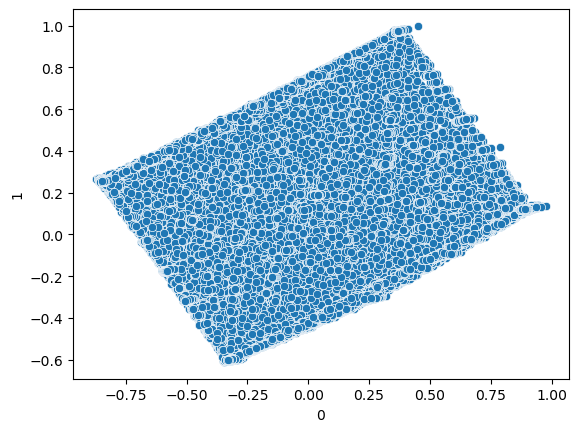

In [55]:
import seaborn as sns

sns.scatterplot(data=df_PCA, x=0, y=1)

No obvious groups gotten from PCA.

Here we pick 4 authors that are furthest away from the center and each other (4 corner of our graph), assuming they write completly opposite tweets and to completly different audiences. 

In [56]:
author_ids = {'author1': 147750, 'author2': 122786, 'author3': 119708, 'author4': 88487}

    
df_PCA['label'] = ' '
df_PCA.loc[list(author_ids.values()),'label'] = 'selected'
df_PCA.iloc[list(author_ids.values())]

,0,1,2,author,index,label
147750,0.979184,0.137667,-0.255004,1109503615696363520,147750,selected
122786,0.450360,0.998578,-0.190058,783317339416645632,122786,selected
119708,-0.873979,0.263094,-0.119917,738787338281619456,119708,selected
88487,-0.344247,-0.610767,-0.273937,1462634593,88487,selected


[Text(0.5, 1.0, 'PCA: Total Explained Variance: 85.96%'),
 Text(0.5, 0, 'PC 1'),
 Text(0, 0.5, 'PC 2')]

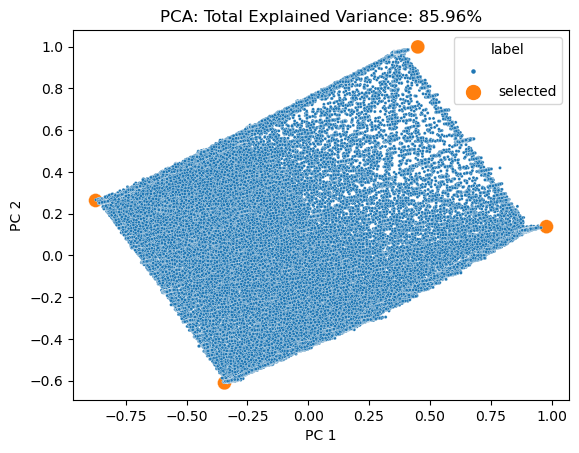

In [63]:
total_var = pca.explained_variance_ratio_.sum() * 100
sns.scatterplot(data=df_PCA, x=0, y=1, hue="label", size="label",sizes=(100, 5)).set(title=f'PCA: Total Explained Variance: {total_var:.2f}%', xlabel='PC 1', ylabel='PC 2')

In [67]:
audience_words = {}
for i in author_ids.keys():
    author_embd = torch.from_numpy(author_embeddings.iloc[author_ids[i]].iloc[:300].to_numpy()).to("cuda")
    scores = (words @ params_cuda[1].T + (
        author_embd * (words @ params_cuda[0].T)).sum(
        axis=1, keepdim=True)).to("cpu").numpy().squeeze(1)
    
    
    diff = (scores - word_dict['latent_scores']).sort_values(ascending=False)[:30]
    audience_words[author_ids[i]] = list(zip(diff.index,diff))
    
    word_dict[i] = scores
    
word_dict.head()

,0,1,2,3,4,5,6,7,8,9,...,298,299,frequency,init_scores,meta_scores,latent_scores,author1,author2,author3,author4
the,-0.051744,0.073964,-0.013057,0.044727,-0.034320,0.021217,0.006911,-0.016328,-0.018075,-0.001997,...,0.000448,-0.004193,11618962,0.588201,0.716231,0.051325,-4.579828,-2.685205,0.965578,-0.904382
business,-0.017487,0.020500,0.000451,0.054434,-0.039927,0.062925,0.068717,0.011007,0.015244,0.012434,...,-0.021857,0.010632,111104,-1.599068,-2.592041,-0.900472,0.361254,4.901703,-0.610012,-2.594780
of,-0.000073,-0.187741,-0.071051,-0.463249,0.000198,0.011507,-0.058770,0.057424,-0.027523,-0.003555,...,-0.138433,0.018054,5963667,1.241262,1.044380,0.458260,13.636809,3.190364,-1.604078,-7.724057
businesses,-0.061112,-0.004327,-0.012538,0.023134,-0.034560,0.070083,0.032714,0.021947,0.022434,-0.024259,...,0.047284,0.040676,40576,-1.746584,-2.988426,-1.558375,-1.499521,2.473840,-0.911331,-3.820565
is,-0.097761,-0.208274,-0.103724,-0.016017,-0.240252,-0.044891,0.002990,0.099000,-0.040384,-0.050430,...,-0.224439,0.088975,3573270,2.576236,2.264979,0.137382,-6.144393,15.192726,-1.046744,-12.522986


In [68]:
# sample some of the results we obtained
for value in list(audience_words.values()):
    print(' '.join([w[0] for w in value])) # names
    print("=" * 100)

gk m0 dq 9x 3w i7 i5 tx 3y us1 pj nj 625k 3d1 p4 p9 ax icq vb cwt pw 86m 7m ezz cw 9w qx 99m qu 88s
vb pw m0 tx gk i7 doji 3y qu 1q qx qa ntc vs 0p bsh jv ru 3bn lbf x00 dmp crh cwt fm va cfd mgt cfds uq
eb 2i y8 5l 3i 4e q3 2l vz 5e cfb 6a 9a i6 3e 9b 8l 3f xg m3 4l 4i wz 5b blz fx 4f 7l kz 9c
eb r4 zis hq rmx kz gct m3 3i kl sv sl bkg g7 cm cfb 9e z6 xo y8 blz sj q6 9l atf dj mm 3f fx nm


In [69]:
word_dict_freq = word_dict[(word_dict['frequency'] > 1) & ( word_dict['frequency'] < 0.7e7)]
np.array(word_dict_freq.sort_values(by='author1', ascending=False).index)[0:200]

array(['dq', 'gk', 's8', 'i7', '9x', 'i5', '3w', 'p4', 'p9', 'us1', 'lb',
       'tx', 'o2z', '86m', 'ezz', 'pw', 'lbf', 'qx', '7m', 'pj', 'ax',
       'p8', 'kg', 'vb', 'cwt', '0p', '9w', 'vez', '6v', '625k', 'p7',
       'dmp', '5mw', 'nj', '99s', 'p6', '6d', 'sq', 'sar', 'kr', '7d',
       'us3', 'xr', 'sr', '0d', 'icq', 'fm', 'us7', 'hk', 'qu', '757',
       'tcb', 'lox', 'cw', 'eph', '30d', 'mpir', 'mi', '99m', '843',
       '866', 'm4', '37p', 'rf', 'rx', 'us2', 'wpm', '288b', 'oq', 'g6',
       '727', 'hcg', '01494', 'lm', '8n', 'lpg', '4d', '3mo', 'gbp', 'h3',
       '888', 'p5', '67p', '3y', '1w', '7w', 'p100', '817', 'gpc', 'ctx',
       'starf', 'ham', 'rc', 'wm', 'ago2', 'yac', 'nh', 'spey', 'vs',
       'yk', 'raj', '717', 'uk', 'p14', 'i95', 'sml', 'j7', '845',
       '01642', 'roe', 'jr', 'p3', '855', 'mhz', 'mc', '6lb', '7653',
       'ggl', 'nsa', 'mq', '22x', '3c3', '603', '0191', 'kjv', 'lr',
       '706', 'msn', 'adm', 'lg', '01782', 'p36', '775', '5d', '713',
     

In [70]:
np.array(word_dict_freq.sort_values(by='author2', ascending=False).index)[0:200]

array(['vb', 'pw', 'i7', 'qx', 'tx', 'lbf', 'hk', '0p', 'uq', '3bn',
       'dmp', 'obc', 'va', 'bsh', 'x00', 'adm', 'qu', 'wmw', 'gk', 'cwt',
       'doji', '2ho', '5p', 'fm', 'adb', 's8', 'g6', 'ntc', 'gbp', 'cfd',
       'tcb', 'ru', 'lb', 'vs', '6bn', 'p9', '30yr', 'sbi', 'i5', 'kg',
       '1q', 'nuc', 'q10', 'h4', 'sov', 'tgt', 'pry', 'ggl', 'lnk', '4bn',
       'o2z', 'sag', 'mgt', 'bn', 'nkw', 'wag', 'jv', 'sar', 'ubb', '5mw',
       '3lb', 'dbr', 'iet', 'tug', 'gfe', 'lm', 'itm', 'qna', 'pdl',
       'gco', 'pds', 'sfr', '99s', '1v', 'nyj', '5bn', 'cfds', 'ipo',
       'cfl', '3w', 'woo', '8bn', 'ucc', 'wso', 'yih', 'gpc', 'siu',
       'xtz', 'kp', 'crh', 'tzu', 'yk', '1ct', 'hum', 'jpy', 'sfc', 'upc',
       '6lb', 'j7', 'nsa', 'rsq', 'bmi', 'az', 'am', 'hua', 'qotw',
       'nucs', 'cpf', '3y', 'ye', 'pqe', 'mull', '8n', 'lmt', '7pc', 'nj',
       'etf', 'pct', 'raj', 'fai', 'iud', 'tmj', 'spey', 'sensex', 'sahm',
       'fwb', 'plex', '3fm', 'qid', 'us1', '6kg', 'jbm', 'lc

In [71]:
np.array(word_dict_freq.sort_values(by='author3', ascending=False).index)[0:200]


array(['kz', 'm3', 'hf', 'zis', 'sl', 'm2', 'atf', 'cm', 'eb', 'o3', 'hz',
       'm7', '8o', 'm8', '2o', 'mc2', 'cc', 'k6', 'ww2', 'mp', 'bkg',
       'x9', 'oq', 'ch3', '3th', 'pz', '1s', 'km2', '5o', 'ha', 'tbm',
       'ww1', '60', 'xx', 'pp', '50', 'ch1', '6o', 'kyr', 'mesi', 'ch4',
       'x13', '4o', 'km3', 'g9', 'aq', '5l', '2e', '8l', 'wz', '90', 'ps',
       'o7', 'k7', 'b3w', 'ch2', 'ed', '1m2', '40', 'g7', '2s', 'ww3',
       'av', 'm9', '70', 'q7', 'kwc', 'k10', 'r4', 'mio', '1tr', '52',
       '4e', '6gw', '48', '80', 'hp', 'da', 'sv', 'whoah', 'voz', '15cm',
       '20', 'ecc', 'q3', 'l6', 'dmf', 'ss', '2i', 'up', 'dw', 'ffs',
       'dq', 'le', 'kpss', '58', 'mw2', 'dsi', '6cp', '46', 'oxo', 'fps',
       '2th', '51', 'ghz', '30', '80x', 'l9', '5ths', '53', '30h', 'ult',
       'spreed', '8e', 'hl', 'octaves', 'rtf', 'bl47', '45', 'ggfi',
       '20cm', 's8', 'x3', 'blz', 'hh', 'no3', '3o', 'rds', '59', '9per',
       '33', '57', '43', '41', 'cd', 'fkn', '2cd', '15', '4

In [72]:
np.array(word_dict_freq.sort_values(by='author4', ascending=False).index)[0:200]

array(['zis', 'sl', 'cm', 'kz', 'eb', 'r4', 'k7', 'hq', 'm3', 'g7', 'bkg',
       'atf', 'sj', 'nm', 'sv', '9e', 'gct', 'o3', 'q6', 'da', 'km2',
       'a9', 'lx', 'mm', 'lp', 'cd2', 'o2', 'hz', 'g9', 'x9', 'cd1', 'b9',
       'blz', 'cc', 'xx', 'uk', 'b3', 'q7', 'kl', 'rmx', 'w1', 'nr', 'sq',
       'wq', 'r6', 'hh', '9l', 'mg', 'ed', '2cd', 'oq', 'bpm', 'av',
       'arf', 'bgs', 'nmi', 'hp', 'dq', 'q5', 'ha', '8e', 'maio', 'nz',
       '72h', 'mp', 'r5', 'm8', 'fps', '2e', 'jp', 'km3', 'atb', 'fx',
       'w3', 'xo', 'e3', 'o7', 'ghz', 'bloor', 'odr', 'gq', '6e', 'kyr',
       '48h', 'm2', 'fbi', 'wub', '8o', 'ctte', '7e', 'dpa', 'kei', 'u2',
       'dj', 'voz', 'hoy', 'snl', 'bph', 'fkk', 'nyt', 'rct', 'tbn', 'b8',
       'ww2', 'julho', 'lv', '8l', 'efa', 'ff7', '4e', 'k6', 'lsd', 'uks',
       'gj', 'cd3', 'dk', 'ja', 'k5', 'vox', '8h', 'c4c', 'oecd', 'hl',
       'cd', 'ramo', 'oh', 'asl', 'othes', 'tfs', 'x3', 'sk8', 'gil',
       'dsi', 'bg', 'nk', 'foz', 'zedd', 'ft', 'vio', 

**Here we can infer that 4 authors do acutally have different perferred words. The same trends still exist among the four authors, such as there are many numbers, but one can see that there are still significant differences between these words. We can even infer from these words that the topics each of them focuses on are also different.**

### K-means clustering

In [73]:
from sklearn.cluster import KMeans

  0%|          | 0/18 [00:00<?, ?it/s]

Text(0, 0.5, 'Sum of Squared Errors')

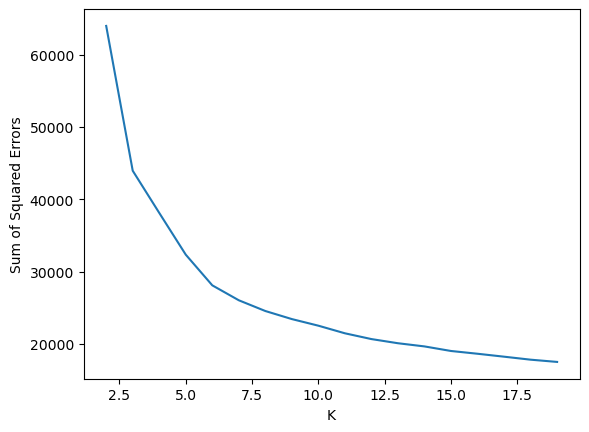

In [74]:
sse = [] 
X = author_embeddings.to_numpy()
# Try multiple k
for k in tqdm(range(2, 20)):
    # Cluster the data and assigne the labels
    kmeans = KMeans(n_clusters=k, random_state=10).fit(X)
    sse.append({"k": k, "sse": kmeans.inertia_})

sse = pd.DataFrame(sse)
# Plot the data
plt.plot(sse.k, sse.sse)
plt.xlabel("K")
plt.ylabel("Sum of Squared Errors")

Optimal number of clusters is 6.

In [75]:
labels = KMeans(n_clusters=6, random_state=10).fit_predict(X)
labels.shape

(209309,)

In [77]:
author_embeddings["Cluster"] = labels
author_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,296,297,298,299,300,301,302,303,304,Cluster
22,-0.011832,0.000088,0.004434,0.038730,-0.047330,0.003657,0.012779,0.003983,-0.000961,-0.002555,...,0.010975,0.123918,-0.006615,0.011359,0.923077,0.000000,0.0,0.0,0.384615,5
224,-0.026187,-0.029001,0.015409,0.040204,-0.054712,-0.013778,0.028484,-0.008869,0.016860,-0.007510,...,0.019806,0.111667,-0.002293,0.005656,0.550000,0.000000,0.0,0.0,0.450000,5
246,-0.021350,-0.006799,0.015069,0.035720,-0.034636,-0.010558,0.014174,0.001210,0.000823,-0.000146,...,0.003462,0.091501,-0.001289,0.010120,0.600000,0.000000,0.0,0.0,0.600000,1
985,-0.026778,-0.007398,-0.000153,0.027064,-0.040457,0.002891,0.028420,0.028276,0.006746,0.006383,...,0.019486,0.110385,0.001277,0.013667,1.000000,0.888889,0.0,0.0,0.222222,3
989,-0.008732,-0.005052,-0.001882,0.025752,-0.028201,0.004804,0.020816,0.001998,-0.005596,-0.007725,...,-0.001252,0.130954,-0.010536,0.012593,1.000000,0.100000,0.0,0.0,0.400000,5


In [78]:
audience_words = []
for k in range(0, 6):
    author_embd = torch.from_numpy(
        author_embeddings[author_embeddings["Cluster"] == k].mean()[:300].to_numpy()).to("cuda")
    scores = (words @ params_cuda[1].T + (
        author_embd * (words @ params_cuda[0].T)).sum(
        axis=1, keepdim=True)).to("cpu").numpy().squeeze(1)

    diff = (scores - word_dict['latent_scores']).sort_values(ascending=False)[:30]
    audience_words.append(list(zip(diff.index,diff)))
    
    word_dict['cluster_' + str(k)] = scores
    
len(audience_words)

6

In [79]:
# sample some of the results we obtained
for value in audience_words:
    print(' '.join([w[0] for w in value])) # print the name of the author with closest embedding to the avg.
    print("=" * 100)

xg r4 m3 y8 aq 2f cc ml kz 2i kl eb 4l 5l wz 3g hg 2l 6a e3 m9 b3 x9 ug 5e 5g g7 2g gx 3f
r4 kz b3 m3 cc e3 f6 g7 4l 5l wz x9 h6 aq 2f hg o2 2l kl cm i6 m9 wlw r6 dj 3l iz ml 3car e2
tx 3y qu pw lmk us1 x00 m0 nyj 7d vb 8373 yj fwb q1 9x 3d1 xq tcb 30d cwt wx 7p 843 3w 5d 866 kr jv yk
xg r4 m3 aq 4l 2l ml 5l hg iz f6 5g kz cc nk cq eb gz ug 8l 1l wlw 5v 3l 3g dw 2g m9 x9 b3
qa qu 8n wmw ctx wx mgt uq qc x00 tx qb ac s7 sag ntc bsh upc ag vb ubb lm rsq fwb pry lifc cog nyj pw cfl
h6 iz r4 kz 4l 5l 2l wltm m3 8l wlw aq voz h8 b3 8o k8 vom gz 2o naf dj ch3 og 3l 3of ep kkk och f6


In [82]:
word_dict.head()

,0,1,2,3,4,5,6,7,8,9,...,author1,author2,author3,author4,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
the,-0.051744,0.073964,-0.013057,0.044727,-0.034320,0.021217,0.006911,-0.016328,-0.018075,-0.001997,...,-4.579828,-2.685205,0.965578,-0.904382,0.039281,0.033405,-0.270573,0.144740,0.025388,0.253857
business,-0.017487,0.020500,0.000451,0.054434,-0.039927,0.062925,0.068717,0.011007,0.015244,0.012434,...,0.361254,4.901703,-0.610012,-2.594780,-0.876126,-1.043848,-0.628173,-0.928235,-0.750027,-1.048422
of,-0.000073,-0.187741,-0.071051,-0.463249,0.000198,0.011507,-0.058770,0.057424,-0.027523,-0.003555,...,13.636809,3.190364,-1.604078,-7.724057,-0.250233,-0.028922,1.538464,0.175880,0.626275,0.515014
businesses,-0.061112,-0.004327,-0.012538,0.023134,-0.034560,0.070083,0.032714,0.021947,0.022434,-0.024259,...,-1.499521,2.473840,-0.911331,-3.820565,-1.457299,-1.658041,-1.450538,-1.540163,-1.486019,-1.667680
is,-0.097761,-0.208274,-0.103724,-0.016017,-0.240252,-0.044891,0.002990,0.099000,-0.040384,-0.050430,...,-6.144393,15.192726,-1.046744,-12.522986,-0.295648,-0.144753,0.219955,0.099684,0.418467,0.461874


In [81]:
word_dict_freq = word_dict[(word_dict['frequency'] > 1) & (word_dict['frequency'] < 0.7e7)]
np.array(word_dict_freq.sort_values(by='cluster_0', ascending=False).index)[0:200]

array(['s8', 'kg', 'm2', 'k6', 'k5', 'dc', 'k3', 'k4', 'g6', 'qotw', 'ck',
       'oq', 'hf', 'obc', 'lb', 'k8', 'wmw', 'mv', 'sc', 'g8', 'f9', 'dq',
       'm1', 'kv', 'ico', 'mc2', 'pz', '9per', 'k7', 'sh', '288b', 'f6',
       'niva', 'mc', '1v', 'sq', 'km2', '9951', 'bjp', 'm7', 'ha', 'uv',
       'mp', 'hk', 'c1', 'ch3', 'ctw', 'mh', 'xtz', 'bw', 'g3', 'hdc',
       'frim', 'g1', 'nkw', 'gs', 'k9', 'dukhan', '6kg', 'st1', 'sl',
       'ddamn', 'fu', 'k2', 'cm', 'b3w', '27t', 'pb', 'g2', 'cd', '5o',
       'utf8', 'cks', 'rq', 'm9', 'o2z', 'ps', 'ban', 'pbuh', '30kg',
       'gfe', 'dp', 'ch4', 'acnur', 'g5', 'gtx', 'da', 'qv', 'gsm', 'gv',
       'lcf', 'fkn', 'g9', '1s', '3959', 's2', 'ffs', 'adb', 'nc4', 'bs',
       'o3', 'gnc', 'sqr', '50', 'lbs', 'tsk', 'hha', 'ww3', 'ug', 'bc',
       'ckin', 'naacp', 'disp', '4mt', 'a7', 'o0', '27s', 'cked', 'wgbh',
       'msm', 'ur', 'us41', 'tbm', 'kgs', 'kcal9', 'dukha', '8o', 'cking',
       'wv', 'ddd', '60', '40', 'sr', 'hh', 'ini202

In [83]:
np.array(word_dict_freq.sort_values(by='cluster_2', ascending=False).index)[0:200]

array(['s8', 'kg', 'wmw', 'g6', 'k5', 'lb', 'obc', '288b', 'k3', 'qotw',
       'dc', 'hk', 'k4', 'dq', 'o2z', 'xtz', 'm1', '9per', 'hf', '1v',
       'm2', '6kg', 'qv', 'mv', '6d', 'k6', 'dukhan', 'gfe', 'nkw', 'uv',
       'a7', 'sc', 'mc', 'uq', 'ctw', 'ico', 'lcf', 'lbs', 'pds', 'niva',
       'oq', 'st1', 'sr', 'ck', 'mc2', 'p9', 'frim', 'pz', 'p4', 'utf8',
       'vez', 'us41', 'lbf', '288bn', 'mh', 'adb', '4d', 'acnur', '3fm',
       'kcal9', '9951', 'km2', 'gbp', 'p8', 'gtx', 'starf', 'g2', 'g5',
       'msc', 'wv', 'lpg', 'c1', 'yrs', 'esc', 'kgs', '8n', 'gpc',
       'ddamn', 'sq', 'gsm', '27t', 'x80', 'kv', '3fg', 'duc', '775',
       '4mt', '8064', '92e', 'dukha', 'cu2', '2kg', 'pw', 'wm', '7590',
       'p6', '7380', 'bc', '99s', 'nc4', '67p', 'k7', '95', 'disp', 'g8',
       'qx', '40yrs', '925', 'gnc', '9gw', 'awais', '0s', 'k2', 'ggl',
       '6733', 'k8', 'ktvt', '2pp', '90kg', '27s', 'usn', 'hagee', 'us3',
       'g1', 'clw', 'cr', '85', 'mpir', '30kg', '9n', 'wgbh', 